In [1]:
%cd ..

/home/eli/AnacondaProjects/epych


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import collections
import glob
import functools
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import quantities as pq

import epych

In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
CONDITIONS = ["go_gloexp", "go_seqctl", "lo_gloexp"]
PRETRIAL_SECONDS = 0.5
POSTTRIAL_SECONDS = 0.5

In [7]:
NWB_FILES = glob.glob('/mnt/data/*.nwb')

In [8]:
PILOT_FILES = []

In [9]:
evoked = {}

In [10]:
alignment = epych.statistics.alignment.AlignmentSummary.unpickle("/mnt/data/mice_passiveglo_alignment")

In [11]:
def visual_align(probe_area_counter, probe, signal):
    area = os.path.commonprefix([loc.decode() for loc in signal.channels.location if "VIS" in loc.decode()])
    k = probe_area_counter[(probe, area)]
    probe_area_counter[(probe, area)] += 1
    return alignment.stats[probe + "/" + area].align(k, signal.median_filter().baseline_correct(0., POSTTRIAL_SECONDS))

In [12]:
def samplings(cond):
    probe_area_counter = collections.Counter()
    for f, nwb_file in enumerate(NWB_FILES):
        basename = os.path.splitext(nwb_file)[0]
        if not os.path.exists(basename + "_" + cond):
            continue
        sampling = epych.recording.Sampling.unpickle(basename + "_" + cond).smap(functools.partial(visual_align, probe_area_counter), keys=True)
        yield sampling
        del sampling
        logging.info("Loaded LFPs for %s in subject %s" % (cond, nwb_file))

In [13]:
summaries = {}

In [14]:
def initialize_grand_avg(key, signal):
    area = os.path.commonprefix([loc.decode() for loc in signal.channels.location])
    return epych.statistics.grand.GrandAverage(alignment.stats[key + "/" + area])

In [15]:
for cond in CONDITIONS:
    summaries[cond] = epych.statistic.Summary(initialize_grand_avg)
    summaries[cond].calculate(samplings(cond))
    logging.info("Grand-averaged LFPs for condition %s" % cond)

INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1169714193_ses-1180116198.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1196154905_ses-1211241460.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1196664789_ses-1212569512.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1196167186_ses-1210866107.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1170220951_ses-1186358749.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1186895119_ses-1204677304.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1197684876_ses-1213341633.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1186895128_ses-1203581890.nwb
INFO:root:Loaded LFPs for go_gloexp in subject /mnt/data/sub-1202441642_ses-1217213788.nwb
INFO:root:Grand-averaged LFPs for condition go_gloexp
INFO:root:Loaded LFPs for go_seqctl in subject /mnt/data/sub-1169714193_ses-1180116198.nwb
INFO:root:Loaded LFPs for go_seqctl 

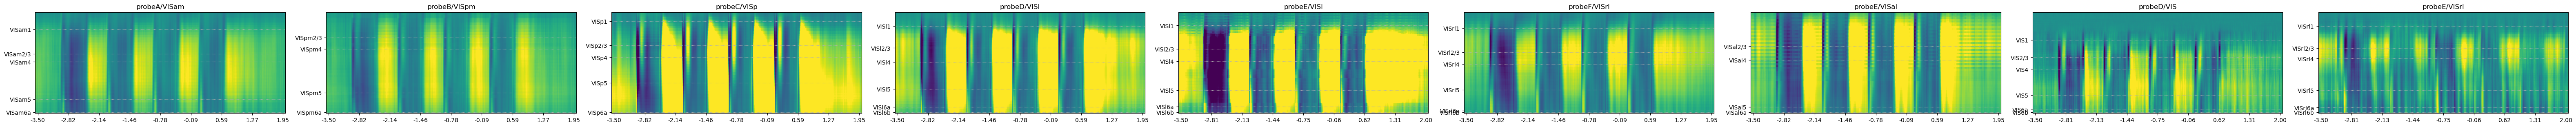

INFO:root:Plotted grand-averaged LFPs for condition go_gloexp


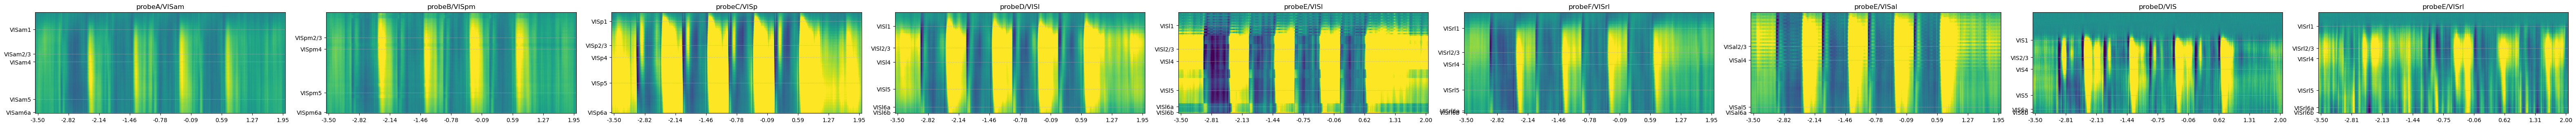

INFO:root:Plotted grand-averaged LFPs for condition go_seqctl


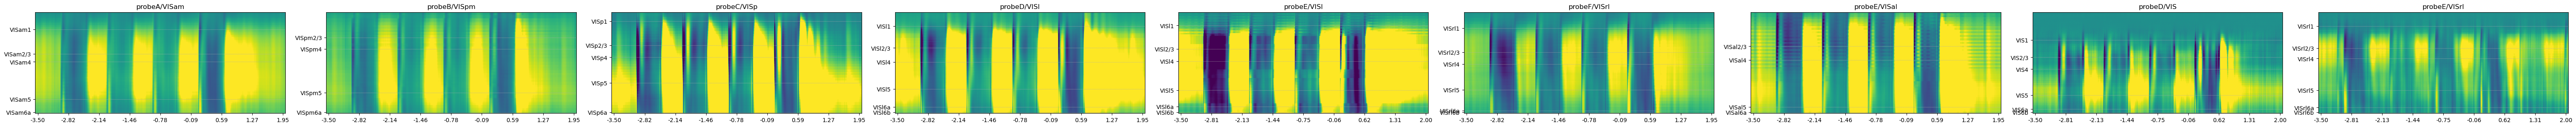

INFO:root:Plotted grand-averaged LFPs for condition lo_gloexp


In [16]:
for cond in CONDITIONS:
    summaries[cond].plot(vmin=-1e-4, vmax=1e-4)
    logging.info("Plotted grand-averaged LFPs for condition %s" % cond)